In [2]:
''' Import libraries '''
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from pyspark import SparkContext
from spark_sklearn import GridSearchCV

from xgboost.sklearn import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

## DATA PREPROCESSING

### Import Datasets

In [3]:
# Define the headers since the data does not have any
headers = ["age", "work_class", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race",
           "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income"]

# Read in the CSV file and convert "?" to NaN
df_train = pd.read_csv("adult_training.csv",
                  header=None, names=headers, na_values="?")
df_test = pd.read_csv('adult_test.csv', 
                      header=None, names=headers, na_values="?")
print('Train Set:',df_train.shape)
print('Test Set:',df_test.shape)

df_train.head()


Train Set: (32561, 15)
Test Set: (16281, 15)


,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


- Education is corresponding to the ranking of "education_num", so they are actually the same things
- We keep the numerical one which is ”education_num” to represent the level of education

In [4]:
# Delete 'education' column
del df_train['education']
del df_test['education']

### One Hot Encoding

Convert categorial values into numerical

In [5]:
train_encoded = pd.get_dummies(df_train)
test_encoded = pd.get_dummies(df_test)

# Different column size because there's a missing value 'Holand-Netherlands' 
# in variable 'native_country' in test set 
print('Train Set Encoded: ',train_encoded.shape)
print('Test Set Encoded: ',test_encoded.shape)

Train Set Encoded:  (32561, 91)
Test Set Encoded:  (16281, 90)


In [6]:
# Delete 'native_country_Holand-Netherlands' column from train set 
del train_encoded['native_country_Holand-Netherlands']

# Delete 'sex_Female' & 'income_<=50K' columns since they are binary value 
# (We keep 'sex_Male' and 'income_>=50K' columns)
del train_encoded['sex_Female']
del train_encoded['income_<=50K']
del test_encoded['sex_Female']
del test_encoded['income_<=50K.']

print('Train Set Encoded: ',train_encoded.shape)
print('Test Set Encoded: ',test_encoded.shape)

Train Set Encoded:  (32561, 88)
Test Set Encoded:  (16281, 88)


We combined train and test set into a single dataset since the aim of this study is to use 10 fold cross validation
to assess the performance of different classifiers, it is not neccessary to keep a separate validation test set

In [7]:
combined_data = np.append(train_encoded, test_encoded, axis=0)
# Split features and labels
X = combined_data[:,0:87]
y = combined_data[:,87]

## METHODS

### Metrics Calculation and Visualisation

In [15]:
""" FUNCTION TO PLOT NORMALIZED CONFUSION MATRIX FROM SKLEARN """
# Adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(matrix, classes,
                          title,
                          cmap=plt.cm.Blues):
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(matrix)

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    threshold = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

""" Functions for Performance Metrics """

def calculate_performance_metrics(y_true, y_pred, train=False):
    metrics = []
    # Calculate accuracy
    metrics.append(accuracy_score(y_true,y_pred)*100)
    if not train:
        # Calculate TP,FP,TN,FN
        cnf_matrix = confusion_matrix(y_true, y_pred)
        # Calculate precision, recall, fscore
        for score in precision_recall_fscore_support(y_true, y_pred, average='macro'):
            if score != None:
                metrics.append(score*100)
        return metrics,cnf_matrix
    else:
        return metrics

def display_performance_metrics(accuracy_test, accuracy_train, precision, recall, fscore, matrix, classifier, runtime):
    print(classifier)
    print('Total runtime is {:0.2f} seconds'.format(runtime))
    print("Test Accuracy: {:0.3f}%".format(np.mean(accuracy_test)))
    print("Train Accuracy: {:0.3f}%".format(np.mean(accuracy_train)))

    cnf_matrix = np.sum(matrix,axis=0) #Sum the TP,FP,TN,FP of 10 folds
    print('Precision: {:0.3f}, Recall: {:0.3f}, F-score: {:0.3f}'.format(np.mean(precision),np.mean(recall),np.mean(fscore)))
    plt.figure()
    # Plot matrix
    plot_confusion_matrix(cnf_matrix, classes=['<50K', '>50K'],
                          title='Confusion matrix, with normalization')
    plt.show()

### 10 fold cross validation

We are using StratifiedKFold to ensure the ratio of samples between 2 classes are similar across each fold

In [9]:
# Sklearn's StratifiedKFold: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
def ten_fold_validation(X,y,classifier):
    # Define a 10 fold model 
    kf = StratifiedKFold(n_splits=10)
    kf.get_n_splits(X)
    # Store performance metrics
    accuracy_test = []
    accuracy_train = []
    precision = []
    recall = []
    fscore = []
    matrix = [] 
    # Check runtime 
    start = time.time()
    # Split data into 10 folds
    for train_index, test_index in kf.split(X,y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        # Train model
        if classifier == 'BINARY NEURAL NETWORK':
            train_scores, test_scores = BinaryNeuralNetwork(X_train, y_train, X_test, y_test)
        elif classifier == 'RANDOM FOREST':
            train_scores, test_scores = RandomForest(X_train, y_train, X_test, y_test)
        elif classifier == 'XGBOOST':
            train_scores, test_scores = XGBoost(X_train, y_train, X_test, y_test)           
        # Store metrics for each fold
        accuracy_test.append(test_scores[0][0])
        accuracy_train.append(train_scores[0])
        precision.append(test_scores[0][1])
        recall.append(test_scores[0][2])
        fscore.append(test_scores[0][3])
        matrix.append(test_scores[1])
    # Calculate and display results
    end = time.time()
    display_performance_metrics(accuracy_test, accuracy_train, precision, recall, fscore, matrix, classifier, end-start) 

### Classifiers

In [11]:
''' RANDOM FOREST '''
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
def RandomForest(X_train, y_train, X_test, y_test):
    
    # These are parameters after tuning
    RFmodel = RandomForestClassifier(
        n_estimators=120, 
        max_features=20, 
        criterion='gini', 
        min_samples_leaf=5, 
        random_state=100, 
        n_jobs=-1, 
        class_weight={0:0.9,1:1})
    
    RFmodel.fit(X_train, y_train)
    # Prediction on test set
    y_pred_test = RFmodel.predict(X_test)
    # Prediction on train set
    y_pred_train = RFmodel.predict(X_train)
    scores_test = calculate_performance_metrics(y_test, y_pred_test)
    scores_train = calculate_performance_metrics(y_train, y_pred_train, True)
    return scores_train, scores_test

''' XGBOOST '''
# http://xgboost.readthedocs.io/en/latest/python/python_api.html
def XGBoost(X_train, y_train, X_test, y_test):
    
    # These are parameters after tuning
    XGBmodel = XGBClassifier(
        silent=True, 
        learning_rate=0.3,
        max_depth=4,
        n_jobs=-1,
        n_estimators=120,
        booster='gbtree',
        objective='binary:logistic')
    
    XGBmodel.fit(X_train,y_train)
    # Prediction on test set
    y_pred_test = XGBmodel.predict(X_test)
    # Prediction on train set
    y_pred_train = XGBmodel.predict(X_train)
    scores_test = calculate_performance_metrics(y_test, y_pred_test)
    scores_train = calculate_performance_metrics(y_train, y_pred_train, True)
    return scores_train, scores_test

''' BINARY NEURAL NETWORK '''
# https://keras.io/models/sequential/
def BinaryNeuralNetwork(X_train, y_train, X_test, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    #Initializing Neural Network
    classifier = Sequential()
    # Adding the input layer and the 1st hidden layer
    classifier.add(Dense(128,
                         input_dim = 87, 
                         kernel_initializer = 'uniform', 
                         activation = 'relu'))
    # Adding the 2nd hidden layer
    classifier.add(Dense(64, 
                         activation = 'relu'))
    # Adding the 3rd hidden layer
    classifier.add(Dense(128, 
                         activation = 'relu'))
    classifier.add(Dropout(0.5))      
    # Adding the output layer
    classifier.add(Dense(1, 
                         activation = 'sigmoid'))
    # Compiling Neural Network
    classifier.compile(optimizer = 'adam', 
                       loss = 'binary_crossentropy', 
                       metrics = ['accuracy'])
    
    # Fitting our model   
    classifier.fit(X_train, y_train, 
                   validation_data=(X_test, y_test), 
                   batch_size = 16, 
                   epochs = 5, 
                   verbose = 1)
    
    # Prediction on test set
    y_pred_test = classifier.predict(X_test)
    y_pred_test = (y_pred_test > 0.5)
    # Prediction on train set
    y_pred_train = classifier.predict(X_train)
    y_pred_train = (y_pred_train > 0.5)
    scores_test = calculate_performance_metrics(y_test, y_pred_test)
    scores_train = calculate_performance_metrics(y_train, y_pred_train)    
    return scores_train, scores_test

### Parameters Tuning

#### Random Forest

In [ ]:
'''
%%time
# https://github.com/databricks/spark-sklearn
# http://scikit-learn.org/0.16/modules/generated/sklearn.grid_search.GridSearchCV.html
sc = SparkContext()
param_grid = {"max_features": ['log2','auto',10,20,None],
              "min_samples_leaf": [1,2,5,10],
              "n_estimators": [10,50,100,120,140],
              "class_weight": [{0:0.8,1:1},{0:0.9,1:1},{0:1,1:1}],
              "criterion": ["gini"],
              "random_state": [100],
              "max_depth": [None],
              "n_jobs": [-1]}
gs = GridSearchCV(sc, estimator=RandomForestClassifier(), param_grid=param_grid, cv=10, scoring=make_scorer(accuracy_score), verbose=1) 
gs.fit(X, y)
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()
'''

#### XGBoost

In [ ]:
'''
%%time
# https://github.com/databricks/spark-sklearn
# http://scikit-learn.org/0.16/modules/generated/sklearn.grid_search.GridSearchCV.html
sc = SparkContext()
param_grid = {
            "silent":[True],
            "learning_rate": [0.3,0.35,0.4],
            "max_depth": [3,4,5],
            "n_estimators": [80,100,120],
            "n_jobs": [-1],
            "objective": ["binary:logistic"],
            "booster": ["gbtree"]
} 
gs = GridSearchCV(sc, estimator=XGBClassifier(), param_grid=param_grid, cv=10, scoring=make_scorer(accuracy_score), verbose=1) 
gs.fit(X, y) 
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()
'''

## EXPERIMENTS

### Random Forest 

RANDOM FOREST
Total runtime is 43.98 seconds
Test Accuracy: 86.772%
Train Accuracy: 89.758%
Precision: 83.046, Recall: 78.997, F-score: 80.698
Normalized confusion matrix
[[0.93906607 0.06093393]
 [0.35911697 0.64088303]]


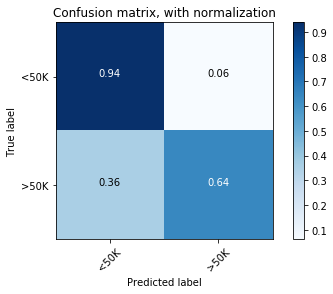

In [15]:
ten_fold_validation(X,y,'RANDOM FOREST')

### XGBoost

/Users/aurelius/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aurelius/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aurelius/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aurelius/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

XGBOOST
Total runtime is 134.04 seconds
Test Accuracy: 87.523%
Train Accuracy: 88.511%
Precision: 84.262, Recall: 79.966, F-score: 81.768
Normalized confusion matrix
[[0.9445835  0.0554165 ]
 [0.34525541 0.65474459]]


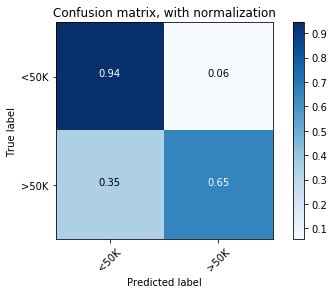

In [12]:
#DeprecationWarning will be displayed due to a bug in XGBoost current model but does not effect the results
ten_fold_validation(X,y,'XGBOOST')

### Binary Neural Network

/Users/aurelius/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 43957 samples, validate on 4885 samples
Epoch 1/5
43957/43957 [==============================] - 6s 131us/step - loss: 0.3353 - acc: 0.8451 - val_loss: 0.3271 - val_acc: 0.8502
Epoch 2/5
43957/43957 [==============================] - 5s 122us/step - loss: 0.3174 - acc: 0.8544 - val_loss: 0.3177 - val_acc: 0.8499
Epoch 3/5
43957/43957 [==============================] - 5s 125us/step - loss: 0.3120 - acc: 0.8570 - val_loss: 0.3180 - val_acc: 0.8504
Epoch 4/5
43957/43957 [==============================] - 5s 111us/step - loss: 0.3088 - acc: 0.8582 - val_loss: 0.3132 - val_acc: 0.8520
Epoch 5/5
43957/43957 [==============================] - 5s 111us/step - loss: 0.3053 - acc: 0.8602 - val_loss: 0.3282 - val_acc: 0.8499
Train on 43957 samples, validate on 4885 samples
Epoch 1/5
43957/43957 [==============================] - 6s 133us/step - loss: 0.3351 - acc: 0.8436 - val_loss: 0.3183 - val_acc: 0.8524
Epoch 2/5
43957/43957 [==============================] - 5s 112us/step - loss: 0

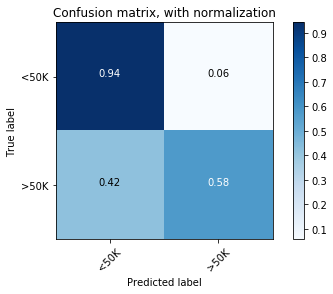

In [16]:
ten_fold_validation(X,y,'BINARY NEURAL NETWORK')